In [107]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import glob
import sys
import cv2 as cv
from tqdm import tqdm
tqdm.pandas()

from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from astropy.io import fits
from astropy.coordinates import SkyCoord
import astropy.units as u

import scipy.stats.distributions as dist

plt.rcParams['font.size'] = 14

In [32]:
combine_fold = 'C:/Users/oryan/Documents/mergers-in-cosmos/cats-to-combine'
data_folder = 'C:/Users/oryan/Documents/mergers-in-cosmos/back-to-basics-data'
fig_folder = 'C:/Users/oryan/Documents/mergers-in-cosmos/paper-source/figures'
cos_dat_fold = 'E:/cosmos-data'

### Importing My Data

In [33]:
df_cat = pd.read_csv(f'{combine_fold}/dor-all-restaged-full.csv', index_col = 0)

C:\Users\oryan\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [34]:
df_cat.head()

,ORyanID_23,ID,category,ALPHA_J2000,DELTA_J2000,X_IMAGE,Y_IMAGE,ERRX2_IMAGE,ERRY2_IMAGE,ERRXY_IMAGE,...,ez_ssfr_p025,ez_ssfr_p160,ez_ssfr_p500,ez_ssfr_p840,ez_ssfr_p975,ez_Av_p025,ez_Av_p160,ez_Av_p500,ez_Av_p840,ez_Av_p975
0,4000705532455,816891,stage4,150.679846,2.196543,9200.399414,21737.232422,0.000052,0.000059,-0.000010,...,-8.931825,-8.911355,-8.899668,-8.883307,-8.872990,0.529107,0.560142,0.599624,0.630920,0.652330
1,4000705533383,860686,stage3,150.644522,2.237226,10047.978516,22713.351562,0.000051,0.000046,0.000002,...,-9.314209,-9.106611,-8.941274,-8.713107,-8.541205,0.341270,0.545498,0.732327,0.906665,1.020098
2,4000705539941,1301188,stage2,149.702462,2.654895,32637.949219,32737.013672,0.000064,0.000104,-0.000003,...,-9.794128,-9.784252,-9.766013,-9.743796,-9.727879,0.018737,0.018737,0.018737,0.018737,0.018737
3,4000705540034,1304538,stage3,149.726828,2.658172,32053.712891,32815.468750,0.000071,0.000086,-0.000006,...,-9.480532,-9.443615,-9.402433,-9.352081,-9.325659,0.302629,0.376027,0.440394,0.508153,0.567727
4,4000705540064,1310001,stage3,149.701230,2.660343,32667.441406,32867.789062,0.000026,0.000020,-0.000010,...,-9.882174,-9.855921,-9.816085,-9.697225,-9.573506,0.455258,0.482555,0.522239,0.600383,0.660279


In [35]:
df_red_tmp = df_cat.query('ez_sfr < 10')
df_red = df_red_tmp.query('lp_mass_best > 6.5')

In [36]:
df_extra_tmp = (
    df_red
    .assign(extra = df_red.ORyanID_23.apply(lambda x: 'y' if type(x) == str else 'n'))
)

df_extra_rem = (
    df_extra_tmp.query('extra == "n"')
)

### Reducing DataFrame

In [37]:
df_ra_dec = (
    df_extra_rem
    [['ORyanID_23', 'ID', 'category', 'ALPHA_J2000', 'DELTA_J2000', 'ez_z_phot', 'lp_zBEST', 'lp_mass_best', 'ez_sfr']]
)

In [38]:
def getting_duplicates(id_str, df):
    
    check = len(df.query('ORyanID_23 == @id_str'))
    if check > 1.5:
        return 'y'
    else:
        return 'n'

In [39]:
def picking_z(ez_z, lp_z):
    if np.isnan(ez_z):
        if not np.isnan(lp_z):
            return lp_z
        else:
            return np.nan
    
    if np.isnan(lp_z):
        if not np.isnan(ez_z):
            return ez_z
        else:
            return np.nan
    
    if lp_z < ez_z:
        return lp_z
    elif ez_z <= lp_z:
        return ez_z
    else:
        return 'what'

### Finding Duplicates

In [40]:
df_checked = (
    df_ra_dec
    .assign(coords = df_ra_dec.apply(lambda row: SkyCoord(ra = row.ALPHA_J2000 * u.deg, dec = row.DELTA_J2000 * u.deg, frame = 'fk5'), axis = 1))
    .assign(filt = df_ra_dec.ORyanID_23.apply(lambda x: getting_duplicates(x, df_ra_dec)))
    .assign(z = df_ra_dec.apply(lambda row: picking_z(row.ez_z_phot, row.lp_zBEST), axis = 1))
)

In [41]:
df_filt = df_checked.query('filt == "y"').drop(columns = ['ez_z_phot', 'lp_zBEST'])
df_filt

,ORyanID_23,ID,category,ALPHA_J2000,DELTA_J2000,lp_mass_best,ez_sfr,coords,filt,z
7,4000705540519,1324712,stage1,149.696134,2.679032,8.85961,-0.291023,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",y,0.283853
11,4000705547180,1264241,stage1,150.319695,2.618060,10.53484,1.474177,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",y,0.982027
12,4000706649921,844303,stage3,150.059115,2.219933,11.05237,2.547000,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",y,1.118725
14,4000707046655,219965,stage1,150.224865,1.618780,9.38022,0.243848,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",y,0.198500
16,4000707047768,246327,stage1,150.197217,1.631803,10.53981,0.066335,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",y,0.204897
...,...,...,...,...,...,...,...,...,...,...
3067,4000854480186,917157,stage3,150.044314,2.288238,10.18464,0.229133,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",y,0.611400
3068,4000858402222,1450508,stage2,150.310093,2.801374,8.00974,-1.172457,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",y,0.135300
3069,4000859156914,793415,stage3,149.653540,2.173049,10.39720,0.951088,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",y,0.593900
3070,4000859744431,1395467,stage3,150.234052,2.746578,10.03151,1.226215,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",y,0.921772


In [42]:
bool_ser = df_filt.duplicated(subset='ORyanID_23', keep='first')

In [43]:
df_prim = (
    df_filt[bool_ser]
    .drop(columns = 'filt')
    .rename(columns = {'ORyanID_23': 'ORyan23_ID_1','ID': 'ID_Prim', 'category' : 'prim_cat', 'ALPHA_J2000': 'Prim_RA','DELTA_J2000' : 'Prim_Dec', 'coords' : 'prim_coords', 'z' : 'z_prim', 'ez_sfr':'ez_sfr_prim','lp_mass_best':'lp_mass_best_prim'})
)
df_sec = (
    df_filt[~bool_ser]
    .drop(columns = 'filt')
    .rename(columns = {'ORyanID_23': 'ORyan23_ID_2', 'ID': 'ID_Sec', 'category' : 'sec_cat', 'ALPHA_J2000': 'Sec_RA','DELTA_J2000' : 'Sec_Dec', 'coords' : 'sec_coords', 'z' : 'z_sec', 'ez_sfr':'ez_sfr_sec','lp_mass_best':'lp_mass_best_sec'})
)

In [44]:
df_prim_sec = (
    df_prim.merge(df_sec, left_on = 'ORyan23_ID_1', right_on = 'ORyan23_ID_2', how = 'left')
)
df_prim_sec

,ORyan23_ID_1,ID_Prim,prim_cat,Prim_RA,Prim_Dec,lp_mass_best_prim,ez_sfr_prim,prim_coords,z_prim,ORyan23_ID_2,ID_Sec,sec_cat,Sec_RA,Sec_Dec,lp_mass_best_sec,ez_sfr_sec,sec_coords,z_sec
0,4000705540519,1324784,stage1,149.699231,2.679556,8.57956,-0.783763,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.303057,4000705540519,1324712,stage1,149.696134,2.679032,8.85961,-0.291023,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.283853
1,4000705547180,1266054,stage1,150.320392,2.620598,10.60467,0.997192,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.995600,4000705547180,1264241,stage1,150.319695,2.618060,10.53484,1.474177,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.982027
2,4000706649921,840582,stage3,150.061821,2.218277,10.84630,1.745799,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",1.152400,4000706649921,844303,stage3,150.059115,2.219933,11.05237,2.547000,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",1.118725
3,4000707046655,214433,stage1,150.227153,1.617348,6.70360,-1.890665,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.217500,4000707046655,219965,stage1,150.224865,1.618780,9.38022,0.243848,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.198500
4,4000707047768,246358,stage1,150.200064,1.632469,10.63540,0.144319,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.227065,4000707047768,246327,stage1,150.197217,1.631803,10.53981,0.066335,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.204897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,4000854480186,917157,stage3,150.044314,2.288238,10.18464,0.229133,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.611400,4000854480186,917450,stage3,150.043229,2.289116,9.86348,0.465022,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.621800
496,4000858402222,1450508,stage2,150.310093,2.801374,8.00974,-1.172457,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.135300,4000858402222,1449463,stage2,150.309534,2.800553,8.12319,-1.228323,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.137034
497,4000859156914,793415,stage3,149.653540,2.173049,10.39720,0.951088,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.593900,4000859156914,791176,stage3,149.654031,2.172352,10.65839,0.340505,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.545800
498,4000859744431,1395467,stage3,150.234052,2.746578,10.03151,1.226215,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.921772,4000859744431,1395057,stage3,150.235280,2.746598,9.95693,1.176297,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.923286


In [45]:
df_check = (
    df_prim_sec
    .assign(check = df_prim_sec.apply(lambda row: 'n' if row.ORyan23_ID_1 != row.ORyan23_ID_2 else 'y', axis = 1))
)

In [46]:
df_check.check.value_counts()

y    500
Name: check, dtype: int64

### Checking Z-Differences

In [47]:
df_z_check = (
    df_prim_sec
    .assign(z_diff = df_prim_sec.apply(lambda row: row.z_prim - row.z_sec, axis = 1))
)

In [48]:
len(df_z_check)

500

In [49]:
df_z_checked = df_z_check.query('z_diff >= -0.1 and z_diff <= 0.1')

In [50]:
df_z_checked

,ORyan23_ID_1,ID_Prim,prim_cat,Prim_RA,Prim_Dec,lp_mass_best_prim,ez_sfr_prim,prim_coords,z_prim,ORyan23_ID_2,ID_Sec,sec_cat,Sec_RA,Sec_Dec,lp_mass_best_sec,ez_sfr_sec,sec_coords,z_sec,z_diff
0,4000705540519,1324784,stage1,149.699231,2.679556,8.57956,-0.783763,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.303057,4000705540519,1324712,stage1,149.696134,2.679032,8.85961,-0.291023,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.283853,0.019204
1,4000705547180,1266054,stage1,150.320392,2.620598,10.60467,0.997192,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.995600,4000705547180,1264241,stage1,150.319695,2.618060,10.53484,1.474177,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.982027,0.013573
2,4000706649921,840582,stage3,150.061821,2.218277,10.84630,1.745799,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",1.152400,4000706649921,844303,stage3,150.059115,2.219933,11.05237,2.547000,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",1.118725,0.033675
3,4000707046655,214433,stage1,150.227153,1.617348,6.70360,-1.890665,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.217500,4000707046655,219965,stage1,150.224865,1.618780,9.38022,0.243848,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.198500,0.019000
4,4000707047768,246358,stage1,150.200064,1.632469,10.63540,0.144319,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.227065,4000707047768,246327,stage1,150.197217,1.631803,10.53981,0.066335,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.204897,0.022168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,4000854480186,917157,stage3,150.044314,2.288238,10.18464,0.229133,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.611400,4000854480186,917450,stage3,150.043229,2.289116,9.86348,0.465022,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.621800,-0.010400
496,4000858402222,1450508,stage2,150.310093,2.801374,8.00974,-1.172457,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.135300,4000858402222,1449463,stage2,150.309534,2.800553,8.12319,-1.228323,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.137034,-0.001734
497,4000859156914,793415,stage3,149.653540,2.173049,10.39720,0.951088,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.593900,4000859156914,791176,stage3,149.654031,2.172352,10.65839,0.340505,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.545800,0.048100
498,4000859744431,1395467,stage3,150.234052,2.746578,10.03151,1.226215,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.921772,4000859744431,1395057,stage3,150.235280,2.746598,9.95693,1.176297,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.923286,-0.001514


In [51]:
df_z_checked.to_csv(f'{combine_fold}/primary-secondary-z-checked.csv')

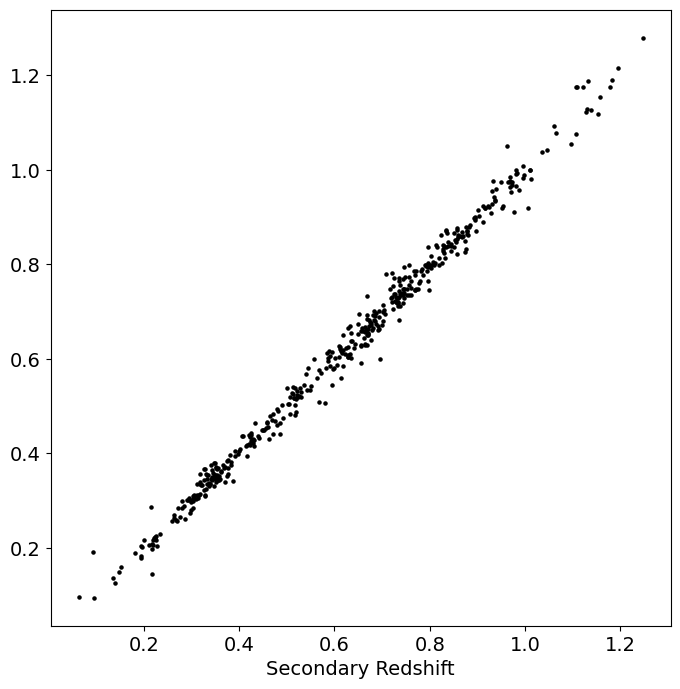

In [52]:
plt.figure(figsize = (8,8))
plt.scatter(df_z_checked.z_prim, df_z_checked.z_sec, s = 5, color = 'black')
plt.xlabel('Primary Redshift')
plt.xlabel('Secondary Redshift')

plt.show()

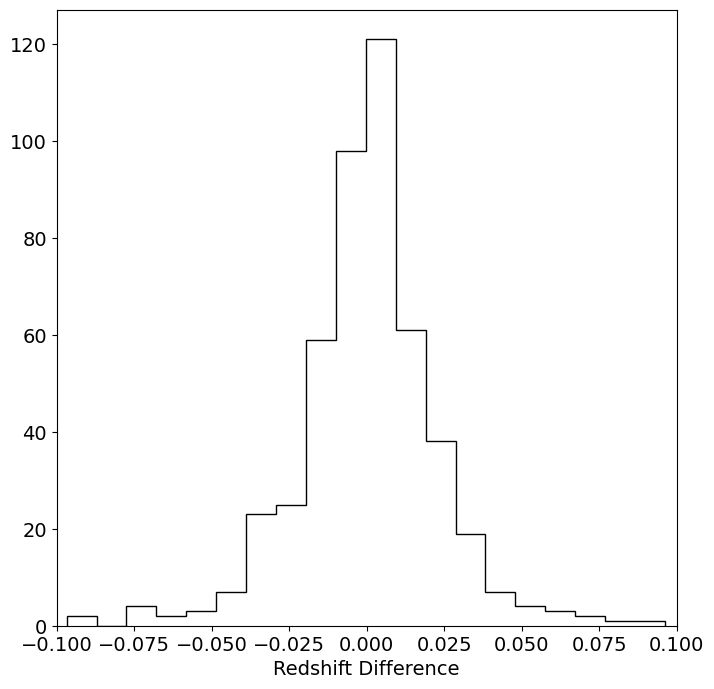

In [53]:
plt.figure(figsize = (8,8))
plt.hist(df_z_checked.z_diff, bins = 20, color = 'black', histtype='step')
plt.xlabel('Redshift Difference')
plt.xlim([-0.1,0.1])
plt.show()

### Getting Projected Separations

In [54]:
cosmo = FlatLambdaCDM(H0=70.0 * u.km / (u.Mpc * u.s), Om0=0.3, Tcmb0=2.725 * u.K)

In [55]:
def calc_seps(prim_ra, prim_dec, sec_ra, sec_dec, z1, z2, cosmo):
    z = (z1 + z2) / 2
    
    prim_coord = SkyCoord(ra = prim_ra * u.deg, dec = prim_dec * u.deg, frame = 'fk5')
    sec_coord = SkyCoord(ra = sec_ra * u.deg, dec = sec_dec * u.deg, frame = 'fk5')
    
    sep = (prim_coord.separation(sec_coord)).to(u.arcmin)
    
    conversion = cosmo.kpc_proper_per_arcmin(z)
    
    proj_dist = (sep * conversion) / u.kpc
    
    return proj_dist

In [56]:
df_seps = (
    df_z_checked
    .assign(proj_seps = df_z_checked.apply(lambda row: np.float64(calc_seps(row.Prim_RA, row.Prim_Dec, row.Sec_RA, row.Sec_Dec, row.z_prim, row.z_sec, cosmo)), axis = 1))
)
df_seps

,ORyan23_ID_1,ID_Prim,prim_cat,Prim_RA,Prim_Dec,lp_mass_best_prim,ez_sfr_prim,prim_coords,z_prim,ORyan23_ID_2,ID_Sec,sec_cat,Sec_RA,Sec_Dec,lp_mass_best_sec,ez_sfr_sec,sec_coords,z_sec,z_diff,proj_seps
0,4000705540519,1324784,stage1,149.699231,2.679556,8.57956,-0.783763,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.303057,4000705540519,1324712,stage1,149.696134,2.679032,8.85961,-0.291023,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.283853,0.019204,49.543741
1,4000705547180,1266054,stage1,150.320392,2.620598,10.60467,0.997192,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.995600,4000705547180,1264241,stage1,150.319695,2.618060,10.53484,1.474177,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.982027,0.013573,75.670970
2,4000706649921,840582,stage3,150.061821,2.218277,10.84630,1.745799,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",1.152400,4000706649921,844303,stage3,150.059115,2.219933,11.05237,2.547000,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",1.118725,0.033675,93.820626
3,4000707046655,214433,stage1,150.227153,1.617348,6.70360,-1.890665,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.217500,4000707046655,219965,stage1,150.224865,1.618780,9.38022,0.243848,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.198500,0.019000,33.048390
4,4000707047768,246358,stage1,150.200064,1.632469,10.63540,0.144319,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.227065,4000707047768,246327,stage1,150.197217,1.631803,10.53981,0.066335,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.204897,0.022168,36.848274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,4000854480186,917157,stage3,150.044314,2.288238,10.18464,0.229133,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.611400,4000854480186,917450,stage3,150.043229,2.289116,9.86348,0.465022,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.621800,-0.010400,33.994232
496,4000858402222,1450508,stage2,150.310093,2.801374,8.00974,-1.172457,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.135300,4000858402222,1449463,stage2,150.309534,2.800553,8.12319,-1.228323,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.137034,-0.001734,8.614547
497,4000859156914,793415,stage3,149.653540,2.173049,10.39720,0.951088,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.593900,4000859156914,791176,stage3,149.654031,2.172352,10.65839,0.340505,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.545800,0.048100,20.020331
498,4000859744431,1395467,stage3,150.234052,2.746578,10.03151,1.226215,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.921772,4000859744431,1395057,stage3,150.235280,2.746598,9.95693,1.176297,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.923286,-0.001514,34.639346


In [57]:
df_seps.proj_seps.min()

3.3952733647909867

In [58]:
df_seps.proj_seps.max()

185.20108998175246

In [59]:
df_seps.query('prim_cat == "stage4"')[['z_prim', 'z_sec',  'proj_seps']]

,z_prim,z_sec,proj_seps
254,0.968700,0.964300,12.923335
364,0.648558,0.652689,10.961991
393,0.933800,0.941700,12.813024


310
146
498


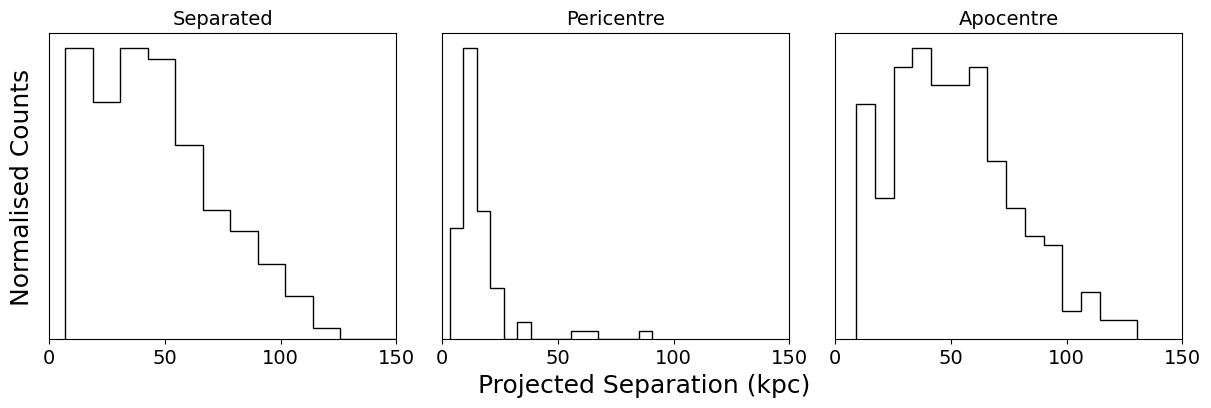

In [60]:
counter = 1
stage_list = ['Separated', 'Pericentre', 'Apocentre']
fig, ax = plt.subplots(ncols = 3, figsize = (12,4))
for i in range(3):
    stage = f'stage{counter}'
    proj_seps = np.array(df_seps.query('prim_cat == @stage').proj_seps)
    proj_seps_double = np.concatenate([proj_seps, proj_seps])

    ax[i].hist(proj_seps_double, bins = 15, histtype='step', color='black', density = True)
    ax[i].set_title(f'{stage_list[i]}', fontsize = 14)
    ax[i].set_xlim([0, 150])
    ax[i].tick_params(left = False, labelleft=False)
    # ax[i].text(115, 65, f'N = {len(proj_seps_double)}', fontsize = 10)
    # ax[i].set_ylim([0,70])
    
    print(len(proj_seps_double))

    counter += 1

fig.tight_layout()
fig.text(-0.01,0.22, 'Normalised Counts', fontsize = 18, rotation = 90, alpha = 1)
fig.text(0.38,-0.01, 'Projected Separation (kpc)', fontsize = 18, alpha = 1)
fig.savefig(f'{fig_folder}/projected-seps.pdf', bbox_inches = 'tight')
plt.show()

### Checking Volume with Separation

In [61]:
df_seps.head()

,ORyan23_ID_1,ID_Prim,prim_cat,Prim_RA,Prim_Dec,lp_mass_best_prim,ez_sfr_prim,prim_coords,z_prim,ORyan23_ID_2,ID_Sec,sec_cat,Sec_RA,Sec_Dec,lp_mass_best_sec,ez_sfr_sec,sec_coords,z_sec,z_diff,proj_seps
0,4000705540519,1324784,stage1,149.699231,2.679556,8.57956,-0.783763,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.303057,4000705540519,1324712,stage1,149.696134,2.679032,8.85961,-0.291023,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.283853,0.019204,49.543741
1,4000705547180,1266054,stage1,150.320392,2.620598,10.60467,0.997192,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.995600,4000705547180,1264241,stage1,150.319695,2.618060,10.53484,1.474177,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.982027,0.013573,75.670970
2,4000706649921,840582,stage3,150.061821,2.218277,10.84630,1.745799,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",1.152400,4000706649921,844303,stage3,150.059115,2.219933,11.05237,2.547000,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",1.118725,0.033675,93.820626
3,4000707046655,214433,stage1,150.227153,1.617348,6.70360,-1.890665,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.217500,4000707046655,219965,stage1,150.224865,1.618780,9.38022,0.243848,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.198500,0.019000,33.048390
4,4000707047768,246358,stage1,150.200064,1.632469,10.63540,0.144319,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.227065,4000707047768,246327,stage1,150.197217,1.631803,10.53981,0.066335,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.204897,0.022168,36.848274


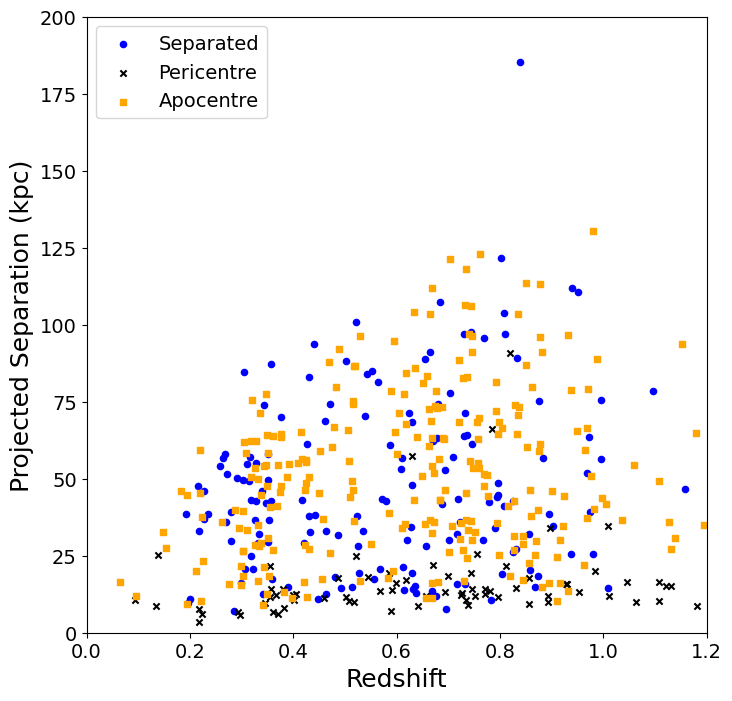

In [62]:
fig, ax = plt.subplots(figsize = (8,8))
colours = ['blue','black','orange']
markers = ['o', 'x', 's']
for i in range(3):
    df_seps.query(f'prim_cat == "stage{i+1}"').plot.scatter(
        x = 'z_prim',
        y = 'proj_seps',
        ax = ax, 
        xlim = [0,1.2],
        ylim = [0,200],
        color=colours[i],
        marker = markers[i]
    )
    
    counter += 1

ax.set_xlabel('Redshift', fontsize = 18)
ax.set_ylabel('Projected Separation (kpc)', fontsize = 18)
ax.legend(['Separated', 'Pericentre', 'Apocentre'], loc= 'upper left')
fig.savefig(f'{fig_folder}/redshift-proj-sep-diagnostic.pdf', bbox_inches = 'tight', dpi = 500)

### Star Formation with Projected Separation

In [63]:
df_seps_red = (
    df_seps[['ORyan23_ID_1', 'ID_Prim', 'ID_Sec', 'z_prim', 'z_sec', 'lp_mass_best_prim', 'lp_mass_best_sec', 'ez_sfr_prim', 'ez_sfr_sec', 'proj_seps', 'prim_cat']]
)

In [64]:
def adding_logs(logx1, logx2):
    x1 = 10**logx1
    x2 = 10**logx2
    x_sum = x1 + x2
    return np.log10(x_sum)

In [65]:
df_sfrs = (
    df_seps_red
    .assign(mass_tot = df_seps_red.apply(lambda row: adding_logs(row.lp_mass_best_prim, row.lp_mass_best_sec), axis = 1))
    .assign(sfr_tot = df_seps_red.apply(lambda row: adding_logs(row.ez_sfr_prim, row.ez_sfr_sec), axis = 1))
)

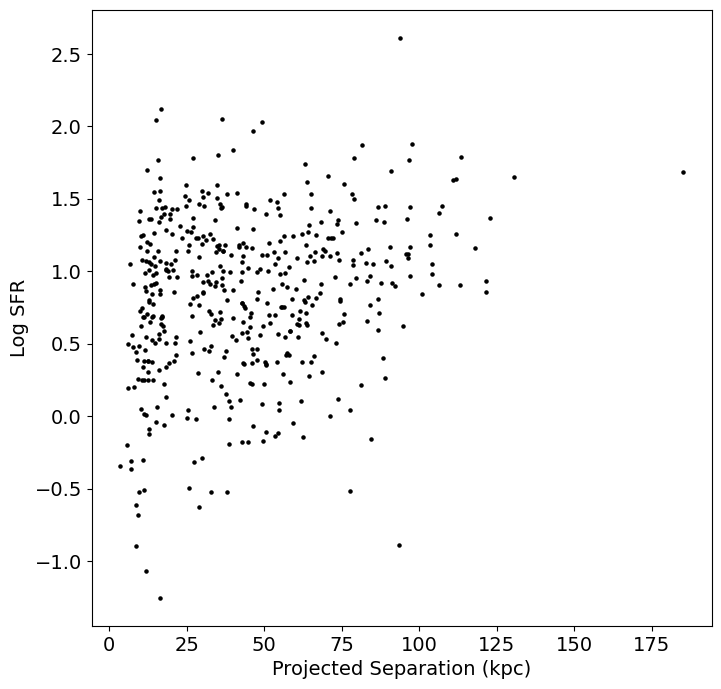

In [66]:
plt.figure(figsize = (8,8))
plt.scatter(df_sfrs.proj_seps, df_sfrs.sfr_tot, s = 5, color = 'black')
plt.xlabel('Projected Separation (kpc)')
plt.ylabel('Log SFR')
plt.show()

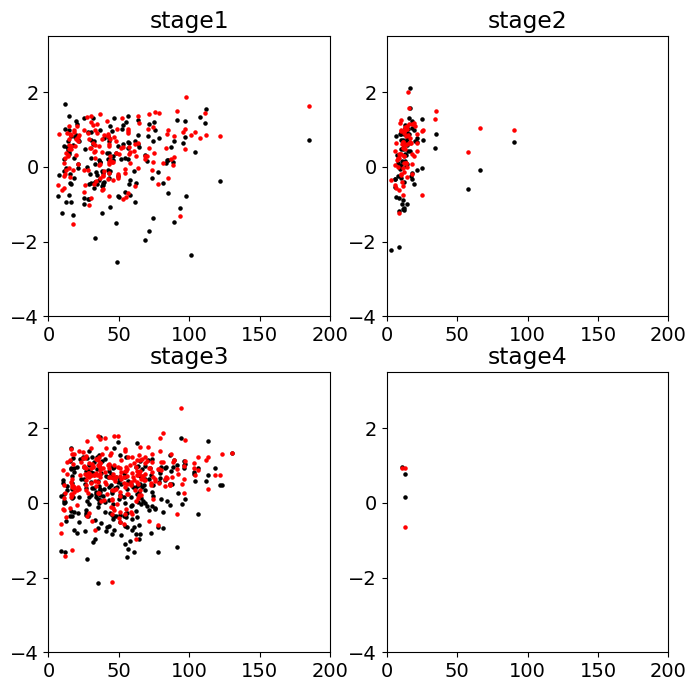

In [67]:
counter = 1
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (8,8))
for i in range(2):
    for j in range(2):
        stage = f'stage{counter}'
        df_stage = df_sfrs.query('prim_cat == @stage')
        
        ax[i,j].scatter(df_stage.proj_seps, df_stage.ez_sfr_prim, s=5, color='black')
        ax[i,j].scatter(df_stage.proj_seps, df_stage.ez_sfr_sec, s=5, color='red')
        ax[i,j].set_title(stage)
        ax[i,j].set_xlim([0, 200])
        ax[i,j].set_ylim([-4,3.5])
        
        counter += 1

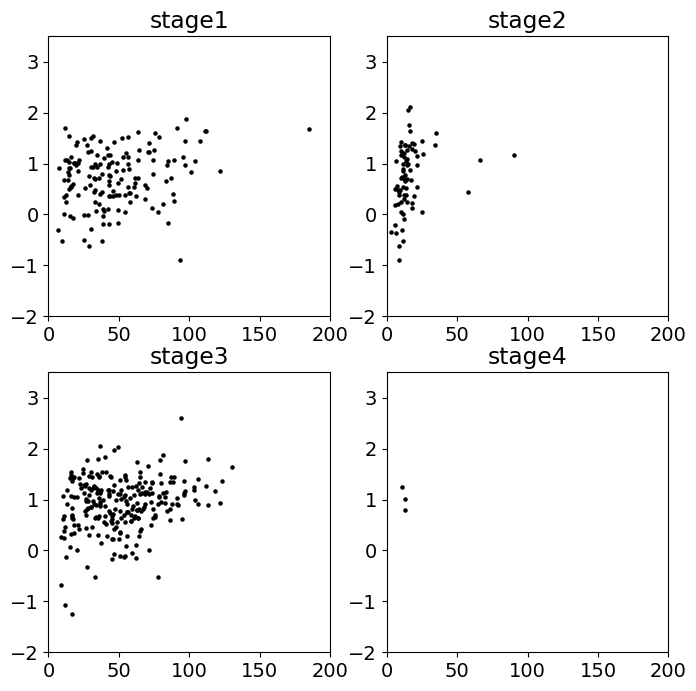

In [68]:
counter = 1
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (8,8))
for i in range(2):
    for j in range(2):
        stage = f'stage{counter}'
        df_stage = df_sfrs.query('prim_cat == @stage')
        
        ax[i,j].scatter(df_stage.proj_seps, df_stage.sfr_tot, s=5, color='black')
        ax[i,j].set_title(stage)
        ax[i,j].set_xlim([0, 200])
        ax[i,j].set_ylim([-2,3.5])
        
        counter += 1

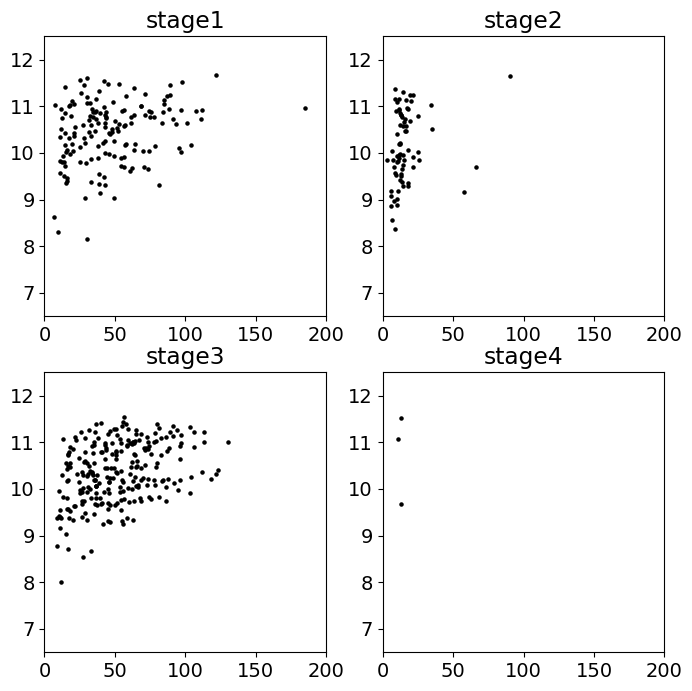

In [69]:
counter = 1
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (8,8))
for i in range(2):
    for j in range(2):
        stage = f'stage{counter}'
        df_stage = df_sfrs.query('prim_cat == @stage')
        
        ax[i,j].scatter(df_stage.proj_seps, df_stage.mass_tot, s=5, color='black')
        ax[i,j].set_title(stage)
        ax[i,j].set_xlim([0, 200])
        ax[i,j].set_ylim([6.5,12.5])
        
        counter += 1

### Binning Star Formation Rate
Here, I want to just focus on amount of SFR with projected separation. Follow Etkas plots? Hers use SFR enhancement, which sucks a bit. Going to have to just look at change in mean separation, I think

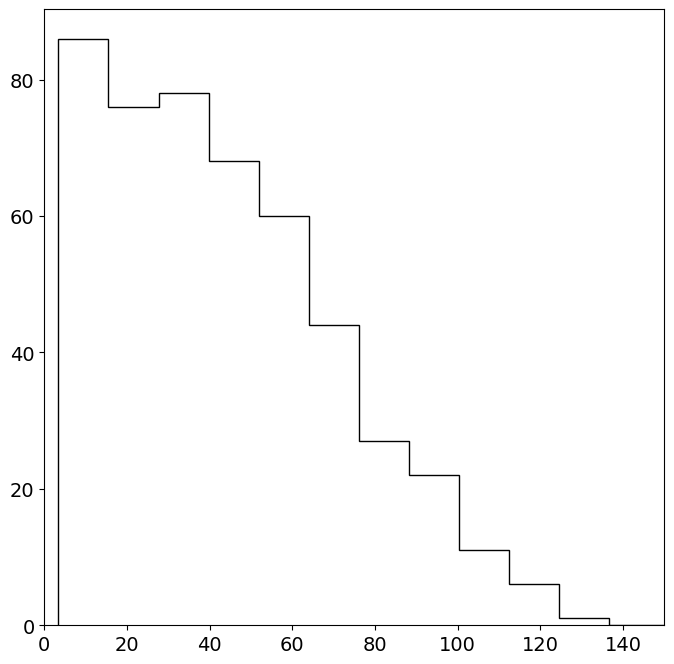

In [70]:
plt.figure(figsize = (8,8))
plt.hist(np.asarray(df_sfrs.proj_seps), bins = 15, histtype='step', color = 'black')
plt.xlim([0,150])
plt.show()

In [71]:
bins = np.linspace(0,150,8)

In [72]:
bins

array([  0.        ,  21.42857143,  42.85714286,  64.28571429,
        85.71428571, 107.14285714, 128.57142857, 150.        ])

In [73]:
df_lin_sfr = df_sfrs.assign(lin_sfr_tot = df_sfrs.sfr_tot.apply(lambda x: 10**x))

In [74]:
sfr_tot = np.zeros(len(bins))
sfr_hist = np.zeros(len(bins))

In [75]:
for i in range(len(bins)-1):
    min_d = bins[i]
    max_d = bins[i+1]
    
    sfr_all_df = df_lin_sfr.query('proj_seps >= @min_d and proj_seps < @max_d')
    
    sfr_hist[i] = len(sfr_all_df)
    sfr_tot[i] = sfr_all_df.lin_sfr_tot.sum()

In [76]:
sfr_avg = sfr_tot / sfr_hist
sfr_avg[np.isnan(sfr_avg)] = 0.0

C:\Users\oryan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


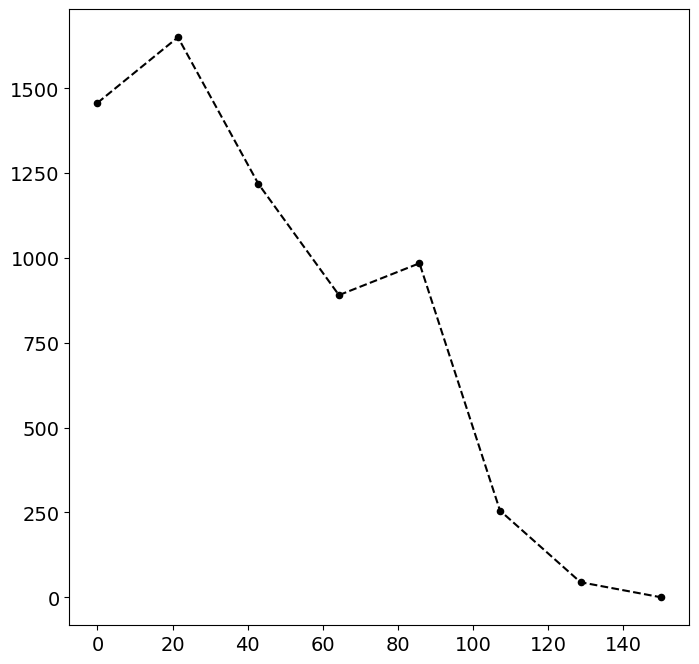

In [77]:
plt.figure(figsize = (8,8))
plt.scatter(bins, sfr_tot, s = 20, color = 'black')
plt.plot(bins, sfr_tot, color = 'black', linestyle='--')
plt.show()

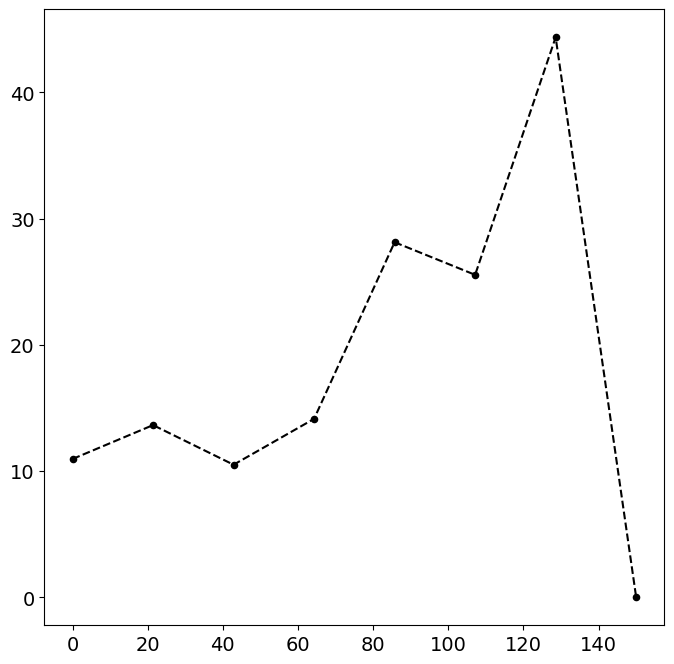

In [78]:
plt.figure(figsize = (8,8))
plt.scatter(bins, sfr_avg, s = 20, color = 'black')
plt.plot(bins, sfr_avg, color = 'black', linestyle='--')
plt.show()

In [79]:
df_sfrs

,ORyan23_ID_1,ID_Prim,ID_Sec,z_prim,z_sec,lp_mass_best_prim,lp_mass_best_sec,ez_sfr_prim,ez_sfr_sec,proj_seps,prim_cat,mass_tot,sfr_tot
0,4000705540519,1324784,1324712,0.303057,0.283853,8.57956,8.85961,-0.783763,-0.291023,49.543741,stage1,9.042808,-0.169937
1,4000705547180,1266054,1264241,0.995600,0.982027,10.60467,10.53484,0.997192,1.474177,75.670970,stage1,10.872187,1.599150
2,4000706649921,840582,844303,1.152400,1.118725,10.84630,11.05237,1.745799,2.547000,93.820626,stage3,11.262474,2.610728
3,4000707046655,214433,219965,0.217500,0.198500,6.70360,9.38022,-1.890665,0.243848,33.048390,stage1,9.381133,0.247023
4,4000707047768,246358,246327,0.227065,0.204897,10.63540,10.53981,0.144319,0.066335,36.848274,stage1,10.891260,0.408105
...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,4000854480186,917157,917450,0.611400,0.621800,10.18464,9.86348,0.229133,0.465022,33.994232,stage3,10.354124,0.663930
496,4000858402222,1450508,1449463,0.135300,0.137034,8.00974,8.12319,-1.172457,-1.228323,8.614547,stage2,8.371189,-0.898462
497,4000859156914,793415,791176,0.593900,0.545800,10.39720,10.65839,0.951088,0.340505,20.020331,stage3,10.848171,1.046307
498,4000859744431,1395467,1395057,0.921772,0.923286,10.03151,9.95693,1.226215,1.176297,34.639346,stage3,10.296849,1.503003


## Looking at SFR Enhancement

In [80]:
df_prim_cont = pd.read_csv(f'{combine_fold}/primary-control-sample.csv', index_col = 0) 
df_sec_cont = pd.read_csv(f'{combine_fold}/secondary-control-sample.csv', index_col = 0)

In [81]:
def calc_enhance(log_sfr, log_control_sfr):
    sfr = 10 ** log_sfr
    
    if log_control_sfr == 0.0:
        return np.nan
    elif np.isnan(log_control_sfr):
        return np.nan
    
    control_sfr = 10 ** log_control_sfr
    return sfr / control_sfr

In [82]:
df_prim_enh = (
    df_prim_cont
    .assign(sfr_enh = df_prim_cont.apply(lambda row: calc_enhance(row.ez_sfr, row.ez_sfr_cont), axis = 1))
)

df_sec_enh = (
    df_sec_cont
    .assign(sfr_enh = df_sec_cont.apply(lambda row: calc_enhance(row.ez_sfr, row.ez_sfr_cont), axis = 1))
)

C:\Users\oryan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in double_scalars
  if __name__ == "__main__":


In [83]:
df_prim_enh

,ORyan_ID,ID,lp_mass_best,ez_sfr,z,Prim_RA,Prim_Dec,control_ID,lp_mass_cont,ez_sfr_cont,sfr_enh
0,4000705540519,1324784,8.57956,-0.783763,0.303057,149.699231,2.679556,1407.0,8.57518,-0.939075,1.429922
1,4000705547180,1266054,10.60467,0.997192,0.995600,150.320392,2.620598,11607.0,10.60752,1.397521,0.397806
2,4000706649921,840582,10.84630,1.745799,1.152400,150.061821,2.218277,78056.0,10.84728,1.717686,1.066873
3,4000707046655,214433,6.70360,-1.890665,0.217500,150.227153,1.617348,144765.0,6.70853,-1.967947,1.194763
4,4000707047768,246358,10.63540,0.144319,0.227065,150.200064,1.632469,26947.0,10.63477,-0.795808,8.712182
...,...,...,...,...,...,...,...,...,...,...,...
475,4000854480186,917157,10.18464,0.229133,0.611400,150.044314,2.288238,254046.0,10.17516,0.062293,1.468385
476,4000858402222,1450508,8.00974,-1.172457,0.135300,150.310093,2.801374,52157.0,8.01636,-1.892681,5.250785
477,4000859156914,793415,10.39720,0.951088,0.593900,149.653540,2.173049,3308.0,10.39488,-2.490311,2763.117579
478,4000859744431,1395467,10.03151,1.226215,0.921772,150.234052,2.746578,1655.0,10.02600,0.813517,2.586410


In [84]:
df_enh_sep_1 = df_prim_enh.merge(df_sfrs[['ORyan23_ID_1', 'proj_seps']], left_on = 'ORyan_ID', right_on = 'ORyan23_ID_1', how = 'left')
df_enh_sep_2 = df_sec_enh.merge(df_sfrs[['ORyan23_ID_1', 'proj_seps']], left_on = 'ORyan_ID', right_on = 'ORyan23_ID_1', how = 'left')

In [85]:
df_enh_sep_1

,ORyan_ID,ID,lp_mass_best,ez_sfr,z,Prim_RA,Prim_Dec,control_ID,lp_mass_cont,ez_sfr_cont,sfr_enh,ORyan23_ID_1,proj_seps
0,4000705540519,1324784,8.57956,-0.783763,0.303057,149.699231,2.679556,1407.0,8.57518,-0.939075,1.429922,4000705540519,49.543741
1,4000705547180,1266054,10.60467,0.997192,0.995600,150.320392,2.620598,11607.0,10.60752,1.397521,0.397806,4000705547180,75.670970
2,4000706649921,840582,10.84630,1.745799,1.152400,150.061821,2.218277,78056.0,10.84728,1.717686,1.066873,4000706649921,93.820626
3,4000707046655,214433,6.70360,-1.890665,0.217500,150.227153,1.617348,144765.0,6.70853,-1.967947,1.194763,4000707046655,33.048390
4,4000707047768,246358,10.63540,0.144319,0.227065,150.200064,1.632469,26947.0,10.63477,-0.795808,8.712182,4000707047768,36.848274
...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,4000854480186,917157,10.18464,0.229133,0.611400,150.044314,2.288238,254046.0,10.17516,0.062293,1.468385,4000854480186,33.994232
476,4000858402222,1450508,8.00974,-1.172457,0.135300,150.310093,2.801374,52157.0,8.01636,-1.892681,5.250785,4000858402222,8.614547
477,4000859156914,793415,10.39720,0.951088,0.593900,149.653540,2.173049,3308.0,10.39488,-2.490311,2763.117579,4000859156914,20.020331
478,4000859744431,1395467,10.03151,1.226215,0.921772,150.234052,2.746578,1655.0,10.02600,0.813517,2.586410,4000859744431,34.639346


In [86]:
df_enh = pd.concat([df_enh_sep_1[['ID', 'proj_seps', 'ez_sfr', 'ez_sfr_cont']], df_enh_sep_2[['ID', 'proj_seps', 'ez_sfr', 'ez_sfr_cont']]]).dropna()

In [87]:
places = [5, 15, 35, 75, 112.5, 137.5]

In [88]:
bins = [1, 10, 20, 50, 100, 125, 150]

In [116]:
enh_bins_all = np.zeros(len(bins)-1)
weights_list = []
error_bins_all = np.zeros(len(bins)-1)

for i in range(len(bins)-1):
    min_d = bins[i]
    max_d = bins[i+1]
    
    df_tmp = df_enh.query('proj_seps >= @min_d and proj_seps < @max_d')
    
    control_sfr_tot = 0
    int_sfr_tot = 0
    
    counts = 0
    int_std = []
    control_std = []   
    for j in range(len(df_tmp)):
        
        int_sfr = 10**df_tmp.ez_sfr.iloc[j]
        cont_sfr = 10**df_tmp.ez_sfr_cont.iloc[j]
        
        if int_sfr > 150:
            continue
        elif cont_sfr > 150:
            continue
            
        counts += 1
        
        int_sfr_tot += int_sfr
        control_sfr_tot += cont_sfr
        int_std.append(int_sfr)
        control_std.append(cont_sfr)
        
    if len(df_tmp) < 10:
        enh_bins_all[i] = 0
        continue
        
    int_sfr_mean = int_sfr_tot / counts
    control_sfr_mean = control_sfr_tot / counts
    
    int_sfr_std = np.std(int_std)
    control_sfr_std = np.std(control_std)
    
    weights_list.append(len(df_tmp))
    
    enh_bins_all[i] = int_sfr_mean / control_sfr_mean
    
    upper_error = dist.beta.ppf((1 - int_sfr_mean) / 2, counts+1, len(df_tmp) - counts + 1)
    lower_error = dist.beta.ppf((1 - (1 - int_sfr_mean)) / 2, counts+1, len(df_tmp) - counts + 1)
    
    error_bins_all[i] = (int_sfr_tot / control_sfr_tot) * np.sqrt((int_sfr_std / int_sfr_tot)**2 + (control_sfr_std / control_sfr_tot)**2)
    
    # sys.exit()
    
df_tmp = df_enh.query('proj_seps >= @max_d')
if len(df_tmp) < 10:
    print('Last bin is tiny.')
    enh_bins_all[-1] = 0.0
    error_bins_all[-1] = 0.0
    
int_std = []
control_std = []
control_sfr_tot = 0
int_sfr_tot = 0
counts = 0
for j in range(len(df_tmp)):

    int_sfr = 10**df_tmp.ez_sfr.iloc[j]
    cont_sfr = 10**df_tmp.ez_sfr_cont.iloc[j]

    if int_sfr > 150:
        continue
    elif cont_sfr > 150:
        continue

    int_sfr_tot += int_sfr
    control_sfr_tot += cont_sfr
    
    counts += 1
        
    int_std.append(int_sfr)
    control_std.append(cont_sfr)

int_sfr_mean = int_sfr_tot / counts
control_sfr_mean = control_sfr_tot / counts

int_sfr_std = np.std(int_std)
control_sfr_std = np.std(control_std)

weights_list.append(len(df_tmp))

enh_bins_all[-1] = int_sfr_mean / control_sfr_mean


error_bins_all[-1] = (int_sfr_tot / control_sfr_tot) * np.sqrt((int_sfr_std / int_sfr_tot)**2 + (control_sfr_std / control_sfr_tot)**2)

Last bin is tiny.


C:\Users\oryan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in double_scalars


In [119]:
error_bins_all

array([1.50716583e-01, 2.69543781e-02, 1.19226935e-02, 1.31803514e-02,
       7.33611205e-02, 3.18745280e+02])

In [120]:
enh_bins

array([0.        , 2.48959887, 1.77645971, 1.35060508, 1.32419619,
       0.        ])

In [121]:
weights_list

[44, 203, 346, 328, 33, 2]

In [122]:
places = [5, 15, 35, 75, 112.5, 137.5]

C:\Users\oryan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  


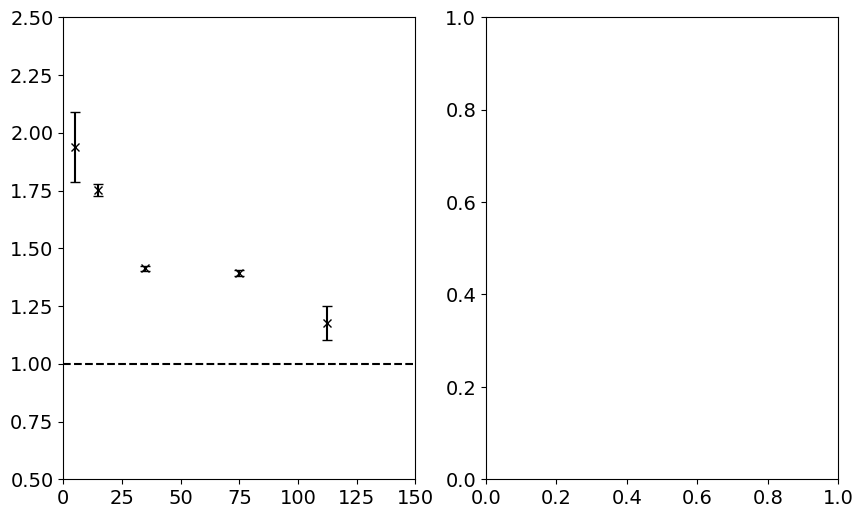

In [177]:
fig, ax = plt.subplots(ncols = 2, figsize = (10,6))
ax[0].errorbar(places, enh_bins_all, color = 'black', marker = 'x', fmt='o', yerr=error_bins_all, label = 'all', capsize = 3.5)
ax[0].axhline(1.0, linestyle = '--', color = 'black')
ax[0].set_xlim([0,150])
ax[0].set_ylim([0.5,2.5])
plt.show()

### Plotting this with Stage

In [178]:
df_cat.head()

,ORyanID_23,ID,category,ALPHA_J2000,DELTA_J2000,X_IMAGE,Y_IMAGE,ERRX2_IMAGE,ERRY2_IMAGE,ERRXY_IMAGE,...,ez_ssfr_p025,ez_ssfr_p160,ez_ssfr_p500,ez_ssfr_p840,ez_ssfr_p975,ez_Av_p025,ez_Av_p160,ez_Av_p500,ez_Av_p840,ez_Av_p975
0,4000705532455,816891,stage4,150.679846,2.196543,9200.399414,21737.232422,0.000052,0.000059,-0.000010,...,-8.931825,-8.911355,-8.899668,-8.883307,-8.872990,0.529107,0.560142,0.599624,0.630920,0.652330
1,4000705533383,860686,stage3,150.644522,2.237226,10047.978516,22713.351562,0.000051,0.000046,0.000002,...,-9.314209,-9.106611,-8.941274,-8.713107,-8.541205,0.341270,0.545498,0.732327,0.906665,1.020098
2,4000705539941,1301188,stage2,149.702462,2.654895,32637.949219,32737.013672,0.000064,0.000104,-0.000003,...,-9.794128,-9.784252,-9.766013,-9.743796,-9.727879,0.018737,0.018737,0.018737,0.018737,0.018737
3,4000705540034,1304538,stage3,149.726828,2.658172,32053.712891,32815.468750,0.000071,0.000086,-0.000006,...,-9.480532,-9.443615,-9.402433,-9.352081,-9.325659,0.302629,0.376027,0.440394,0.508153,0.567727
4,4000705540064,1310001,stage3,149.701230,2.660343,32667.441406,32867.789062,0.000026,0.000020,-0.000010,...,-9.882174,-9.855921,-9.816085,-9.697225,-9.573506,0.455258,0.482555,0.522239,0.600383,0.660279


In [179]:
df_enh_stage = df_enh.merge(df_cat[['ID', 'category']], on = 'ID', how = 'left')

In [180]:
places = [5, 15, 35, 75, 112.5, 137.5]

In [181]:
bins = [1, 10, 20, 50, 100, 125, 150]

C:\Users\oryan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: overflow encountered in double_scalars
C:\Users\oryan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:86: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.


Lengths of list = []
Lengths of list = []
Lengths of list = []


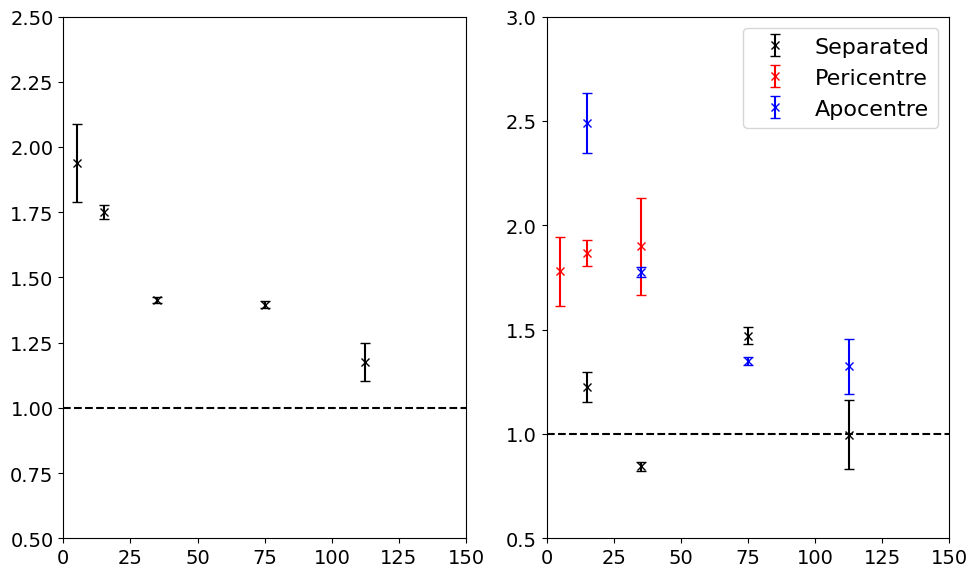

In [182]:
colours = ['black', 'red', 'blue', 'orange']
# stages = ['stage1','stage2','stage3','stage4']
stages = ['Separated','Pericentre','Apocentre']

# fig, ax = plt.subplots(figsize = (8,8))
for h in range(len(stages)):
    
    df_stage = df_enh_stage.query(f'category == "stage{h+1}"')
    
    enh_bins = np.zeros(len(bins)-1)
    count_bins = np.zeros(len(bins)-1)
    weights_list = []
    error_bins = np.zeros(len(bins)-1)
    for i in range(len(bins)-1):
        min_d = bins[i]
        max_d = bins[i+1]

        df_tmp = df_stage.query('proj_seps >= @min_d and proj_seps < @max_d')

        control_sfr_tot = 0
        int_sfr_tot = 0
        int_std = []
        control_std = []
        if len(df_tmp) < 10:
            continue
        for j in range(len(df_tmp)):

            int_sfr = 10**df_tmp.ez_sfr.iloc[j]
            cont_sfr = 10**df_tmp.ez_sfr_cont.iloc[j]

            if int_sfr > 150:
                continue
            elif cont_sfr > 159:
                continue

            int_sfr_tot += int_sfr
            control_sfr_tot += cont_sfr
            
            int_std.append(int_sfr)
            control_std.append(cont_sfr)
        
        int_sfr_mean = int_sfr_tot / len(df_tmp)
        control_sfr_mean = control_sfr_tot / len(df_tmp)
        
        int_sfr_std = np.std(int_std)
        control_sfr_std = np.std(control_std)

        enh_bins[i] = int_sfr_mean / control_sfr_mean
        error_bins[i] = (int_sfr_tot / control_sfr_tot) * np.sqrt((int_sfr_std / int_sfr_tot)**2 + (control_sfr_std / control_sfr_tot)**2)
    
    print(f'Lengths of list = {weights_list}')
    
    df_tmp = df_enh.query('proj_seps >= @max_d')
    if len(df_tmp) < 10:
        enh_bins[-1] = 0.0
        error_bins[-1] = 0.0
    else:
        int_std = []
        control_std = []
        for j in range(len(df_tmp)):

            int_sfr = 10**df_tmp.ez_sfr.iloc[j]
            cont_sfr = 10**df_tmp.ez_sfr_cont.iloc[j]

            if int_sfr > 150:
                continue
            elif cont_sfr > 150:
                continue

            int_sfr_tot += int_sfr
            control_sfr_tot += cont_sfr
            
            int_std.append(int_sfr)
            control_std.append(cont_sfr)

        int_sfr_mean = int_sfr_tot / len(df_tmp)
        control_sfr_mean = control_sfr_tot / len(df_tmp)
        
        int_sfr_std = np.std(int_std)
        control_sfr_std = np.std(control_std)

        enh_bins[-1] = int_sfr_mean / control_sfr_mean
        error_bins[-1] = (int_sfr_tot / control_sfr_tot) * np.sqrt((int_sfr_std / int_sfr_tot)**2 + (control_sfr_std / control_sfr_tot)**2)

    # ax.scatter(places, enh_bins, s = 35, color = colours[h], marker = 'x', label = stages[h])
    ax[1].errorbar(places, enh_bins, yerr=error_bins, fmt='o', color = colours[h], marker = 'x', label = f'Stage {h+1}', capsize = 3.5)
ax[1].legend(['Separated', 'Pericentre', 'Apocentre'],fontsize = 16)
ax[1].axhline(1.0, linestyle = '--', color = 'black')
ax[1].set_xlim([0,150])
ax[1].set_ylim([0.5,3.0])
# ax[1].set_xlabel('Projected Separation (kpc)', fontsize = 18)
# ax[1].set_ylabel('SFR Enhancement', fontsize = 18)
fig.tight_layout()
fig

In [183]:
error_bins

array([0.        , 0.14163779, 0.0231802 , 0.01964961, 0.1315937 ,
       0.        ])

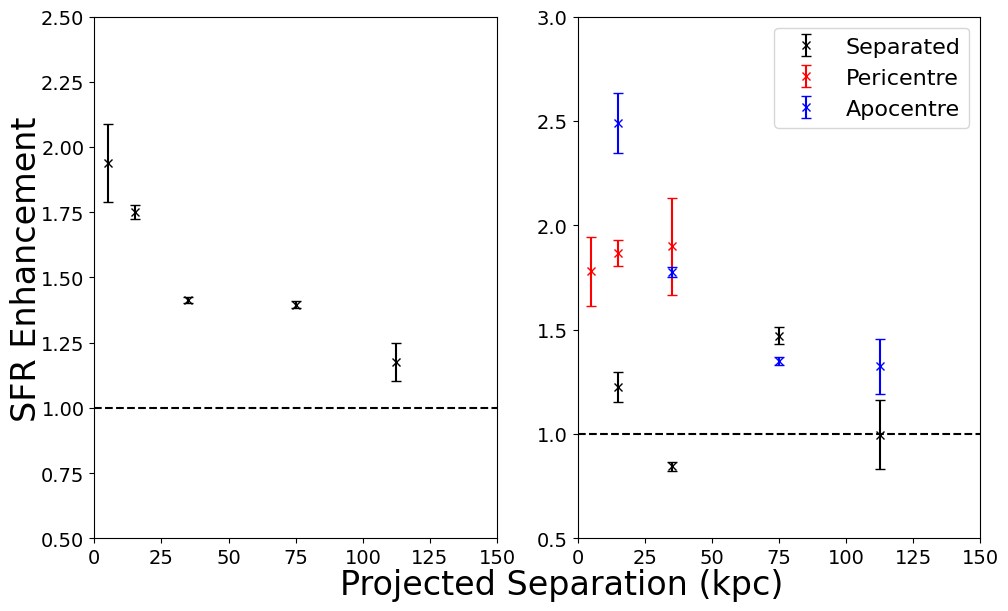

In [184]:
fig.text(-0.01,0.29, 'SFR Enhancement', fontsize = 24, rotation = 90, alpha = 1)
fig.text(0.32,-0.01, 'Projected Separation (kpc)', fontsize = 24, alpha = 1)
fig

In [185]:
fig.savefig(f'{fig_folder}/sfr-enhancement-projected-sep.pdf', bbox_inches='tight')